# LoC Data Package Tutorial: Selected Digitized Books Data Package

This notebook will demonstrate basic usage of using the Pyton library `boto3` for interacting with [data packages from the Library of Congress](https://labs.loc.gov/data/) via the [Selected Digitized Books Data Package](https://labs.loc.gov/data/explore/digitized-books/) which is derived from the Library's [Selected Digitized Books collection](https://www.loc.gov/collections/selected-digitized-books/about-this-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download full text files and visualize it](#Download-full-text-files-and-visualize-it)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the data package contents

In [2]:
import json

import boto3                            # for interacting with Amazon S3 (where the data is stored)
import pandas as pd                     # for reading, manipulating, and displaying data

from helpers import get_s3_bucket_stats

BUCKET_NAME = 'data.labs.loc.gov' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

# This is the name of the data package from the list above; note the trailing slash
DATA_PACKAGE = 'digitized-books/'

stats = get_s3_bucket_stats(s3, BUCKET_NAME, DATA_PACKAGE)

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.json,"84,010",33.05GB
1,.txt,"84,061",31.69GB
2,.jsonl,1,341MB
3,.zip,1,252MB
4,.csv,2,126MB
5,.html,3,52MB
6,.md,3,22KB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular location.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [3]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}metadata.json')
contents = obj.get('Body', '{}').read() # Read contents as a string
data = json.loads(contents).values() # Parse string as JSON
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 90,414 entries.


Next let's convert to pandas DataFrame and print the available properties

In [4]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

access_restricted, aka, campaigns, contributor, date, dates, description, digitized, extract_timestamp, group, hassegments, id, image_url, index, item, language, mime_type, number, number_lccn, number_source_modified, online_format, original_format, other_title, partof, resources, segments, shelf_id, site, timestamp, title, url, number_oclc, type, subject, location, number_preceding_items, partof_title, publication_frequency, location_city, location_country, number_succeeding_items, number_former_id, number_issn, location_state, composite_location, number_carrier_type


Next print the top 10 most frequent subjects in this dataset

In [5]:
# Since "subject" fields are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['subject'].explode().value_counts().iloc[:10].to_frame()

,subject
history,9567
united states,9025
description and travel,3133
politics and government,2467
biography,1823
world war,1716
civil war,1514
poetry,1343
education,1109
grammar,928


Now we filter the results to only those items with subject "poetry"

In [6]:
df_by_subject = df.explode('subject')
subset = df_by_subject[df_by_subject.subject == 'poetry']
print(f'Found {subset.shape[0]:,} items with subject "poetry"')

Found 1,343 items with subject "poetry"


## Download full text files and visualize it

First we download the file manifest.

In [7]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}manifest.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
files = [dict(zip(data["cols"], row)) for row in data["rows"]] # zip columns and rows
files_by_id = dict([(f['item_id'], f['filename']) for f in files]) # create a dict that we can use to easily look up filenames
print(f'Loaded manifest file with {len(files):,} entries.')

Loaded manifest file with 166,218 entries.


Next we load the first 100 text files from the items in the subset

In [25]:
max = 100
found = 0
text = ''
for i, row in subset.iterrows():
    # Derive the filename from the item's id
    item_id = row["id"]
    if item_id in files_by_id:
        filename = files_by_id[item_id]
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}data/{filename}')
        contents = obj.get('Body', '').read() # Read contents as a string
        text += contents.decode("utf-8")
        text += '\n'
        found += 1
    if found >= max:
        break
print(f'Found and loaded {found:,} text files')

Found and loaded 100 text files


And clean up the text by removing non-words

In [30]:
import re

whitespace_pattern = re.compile(r"\s+")
nonword_pattern = re.compile(r" [\S]*[\\\^<>]+[\S]* ")
tinyword_pattern = re.compile(r" [\S][\S]?[\S]? ")
text = text.replace('\\n', '')
text = whitespace_pattern.sub(" ", text).strip()
text = nonword_pattern.sub(" ", text)
text = tinyword_pattern.sub(" ", text)
text = whitespace_pattern.sub(" ", text).strip()
print(text[:100])

b'lis IMHnMH BISHOP HOPKINS LIBRARY CONGRESS. UNITED STATES AMERICA, HISTORY CHUECH, COMPOSED BIBLE-


Finally generate a wordcloud using the text

(-0.5, 399.5, 199.5, -0.5)

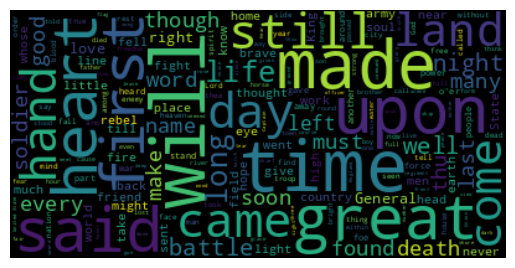

In [31]:
import matplotlib.pyplot as plt         # for displaying data
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")